# Neural network classification
## Definitions

In [166]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

This example uses two distinct classes of points that follow seperate, cluring lines around the center. The generate method generates an arbitrary number of random points. The curling line is defined in polar coordinates

\begin{align}
    \left(\begin{matrix}
        r\\ \phi
    \end{matrix}\right)
    = 
    \left(\begin{matrix}
        \alpha t\\
        t \pm \Delta
    \end{matrix}\right)
\end{align}

with

\begin{align}
    t = \left(\frac{3 s}{2 \alpha} + 1\right)^{2/3}-1
\end{align}

where $s$ is the arc length (integreated line element) from the center, $\alpha=5$ and $\Delta=\frac{\pi}{2}$ are arbitrary constants. The sign of depends on the class of the points.

In [110]:
def generate(n_total, f_H=0.5):
    """
    Returns a dataframe with random training data. The training data contains
    coordinate columns for two classes identified by the value of is_H and
    is_Z.
    """
    is_H = np.random.uniform(size=n_total) < 0.5
    is_Z = ~ is_H
    
    d = np.pi / 2
    a = 5
    
    s = np.random.uniform(330, size=n_total)
    t = (3 * s / a / 2 + 1)**(2/3) - 1
    
    r = a * t
    phi = t + d * is_H - d * is_Z
    phi = phi % (2 * np.pi)
    r *= np.random.normal(loc=1, scale=0.05, size=n_total)
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    
    return pd.DataFrame({
        'x': x,
        'y': y,
        'x-y':  x-y,
        'x+y':  x+y,
        's': s,
        'r': r,
        'phi': phi,
        'is_H': is_H,
        'is_Z': is_Z,
    })

One thousand random sample poins look as follows.

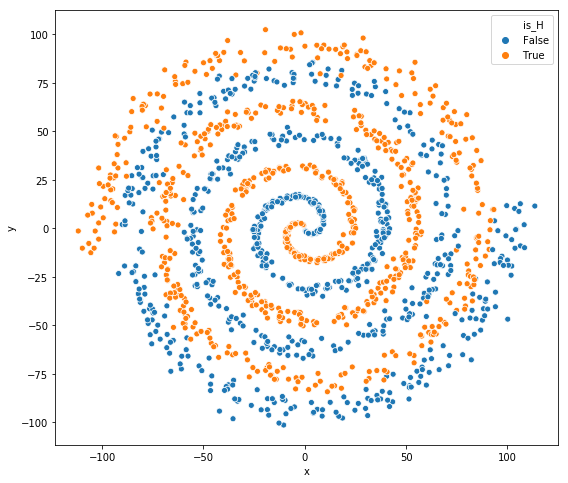

In [111]:
toy_df = generate(1500)
plt.figure(figsize=(9, 8))
sns.scatterplot(x="x", y="y", hue="is_H", data=toy_df)
None

In [112]:
def get_normalization(dataframe):
    """
    Compute moments of the columns of the input dataframe. The method returns
    the mean and the standard deviation. The return value is intended as an
    argument of `normalize()`.
    """
    shift = dataframe.mean()
    shifted = dataframe - dataframe.mean()
    return shift, shifted.std()

def normalize(dataframe, shift, width):
    """
    Applies the normalization. This means the dataframe is shifted to zero-mean
    and scaled to unit-width. The transformed dataframe is returned.
    """
    return (dataframe - shift) / width

The model is train on the following input variables from the dataset.

In [113]:
input_var = ['x', 'y']

The model consists of three hidden layers with `relu` activation and 20 nodes. The output layer has two nodes with softmax activation.

In [178]:
model = Sequential()
model.add(Dense(units=20, activation='relu', input_dim=len(input_var)))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

The model uses `categorical_crossentropy` and `categorical_accuracy` as metric.

In [179]:
sgd_optim = SGD(lr=0.20)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd_optim,
              metrics=['categorical_accuracy'])

Prepare test set:

In [180]:
test_df = generate(N)
in_test = test_df[input_var]
normalization = get_normalization(in_test)
in_test = normalize(in_test, *normalization)
out_test = test_df[['is_H', 'is_Z']]

## Training of the model

Actual training in `n_batches` of size `N`.

In [181]:
N = 512
n_batches = 25*1000

In [182]:
loss_train = []
loss_test = []
metric_train = []
metric_test = []
for i in range(n_batches):
    # Gernerate training data
    train_df = generate(N)
    in_train = normalize(train_df[input_var], *normalization)
    out_train = train_df[['is_H', 'is_Z']]
    
    # Train
    model.train_on_batch(in_train, out_train)
    
    # Evaluate on training set
    loss, metric = model.evaluate(in_train, out_train, batch_size=N, verbose=False)
    loss_train.append(loss)
    metric_train.append(metric)
    
    # Evaluate on test set
    loss, metric = model.evaluate(in_test, out_test, batch_size=N, verbose=False)
    loss_test.append(loss)
    metric_test.append(metric)
    
    m = n_batches // 100
    if len(metric_test) > m and sum(metric_test[-m:]) / m > 0.98:
        break
   

## Evaluation

Visualize loss and metric on training and test set.

/usr/local/lib/python3.5/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


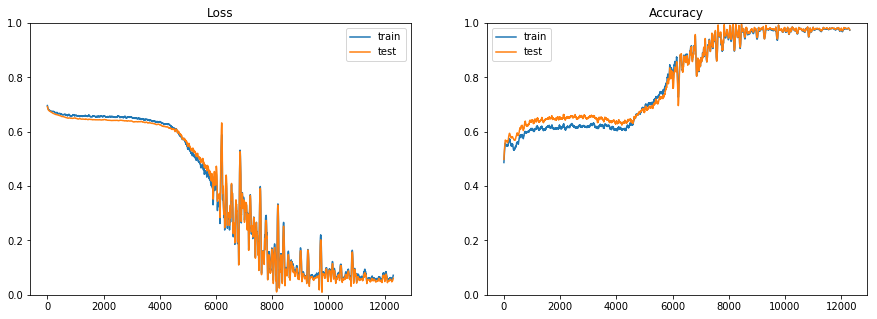

In [183]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(savgol_filter(loss_train, 101, 2), label="train")
plt.plot(savgol_filter(loss_test, 101, 2), label="test")
plt.title("Loss")
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(savgol_filter(metric_train, 101, 2), label="train")
plt.plot(savgol_filter(metric_test, 101, 2), label="test")
plt.title("Accuracy")
plt.ylim((0, 1))
plt.legend()
None

We also want to overlay the toy samples from the beginning with a colored grid map of the output of the classifier.

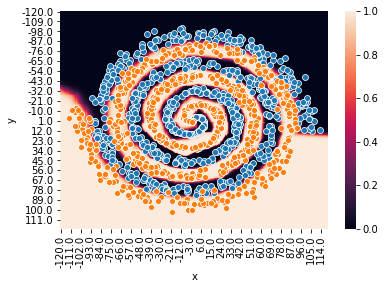

In [184]:
M = int(round(toy_df.x.max() * 1.1, -1))  # Half-range of x and y

# Construct dataframe for every point of a grid
xv, yv = np.meshgrid(np.linspace(-M, M, 2 * M + 1), np.linspace(-M, M, 2 * M + 1))
x = xv.reshape((2 * M + 1)**2)
y = yv.reshape((2 * M + 1)**2)
flat_grid = pd.DataFrame({
    'x': x,
    'y': y,
    'x-y': x-y,
    'x+y': x+y,
    'r': np.sqrt(x**2+y**2),
    'phi': np.arctan2(y, x) % (2 * np.pi)
})

# Selection input variables
flat_grid = flat_grid[input_var]

# Evaluate
result = pd.DataFrame(model.predict(normalize(flat_grid, *normalization)), columns=["is_H", "is_Z"])

# Prepare plot input
flat_grid['is_H'] = result.is_H
map = flat_grid.pivot("y", "x", "is_H")

# Plot
sns.heatmap(map, label="is_H")
sns.scatterplot(x=toy_df[toy_df.is_Z].x +M, y=toy_df[toy_df.is_Z].y + M)
sns.scatterplot(x=toy_df[toy_df.is_H].x +M, y=toy_df[toy_df.is_H].y + M)
None